### Table Content
------------------

- [Introduction](#intro)
- [Import libraries and packages](#ilp)
- [Dataset Information](#di)
- [Separate 'Title' field and preprocess it](#preprocess)
    - [Removing unwanted charaters and words](#remv)
    - [Tokenization and word_index (vocabulary) ](#token)
    - [Convert titles into sequences and Make n_gram model](#ngram)
    - [Make all titles with same length and padding them](#pad)
- [Preprare features (X) and labels (Y)](#xy)
- [Architechture of Bidirectional LSTM neural network](#blstm)
- [Train Bi-LSTM neural network](#train)
- [Plotting accuracy and loss graph](#acc)
- [Predict new title (Testing)](#new)

----------------




<a name="intro"></a>

# Introduction

**Next Word Prediction (also called Language Modeling) is the task of predicting what word comes next. It is one of the fundamental tasks of NLP.**

Image reference: https://medium.com/@antonio.lopardo/the-basics-of-language-modeling-1c8832f21079

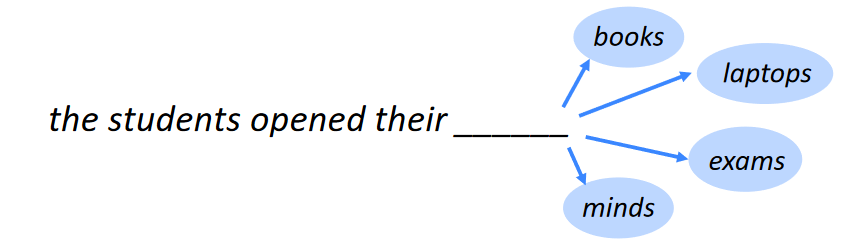

#### Application Language Modelling 

**1) Mobile keyboard text recommandation**

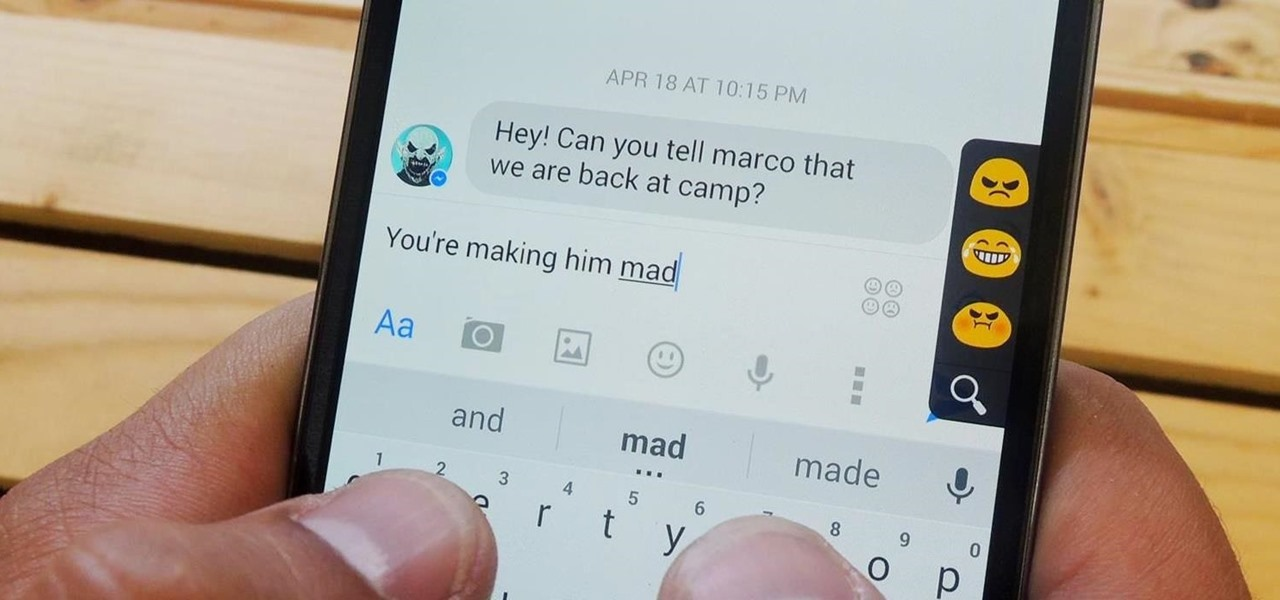

**2) Whenever we search for something on any search engine, we get many suggestions and,  as we type new words in it, we get better recommendations according to our searching context. So, how will it happen??? **

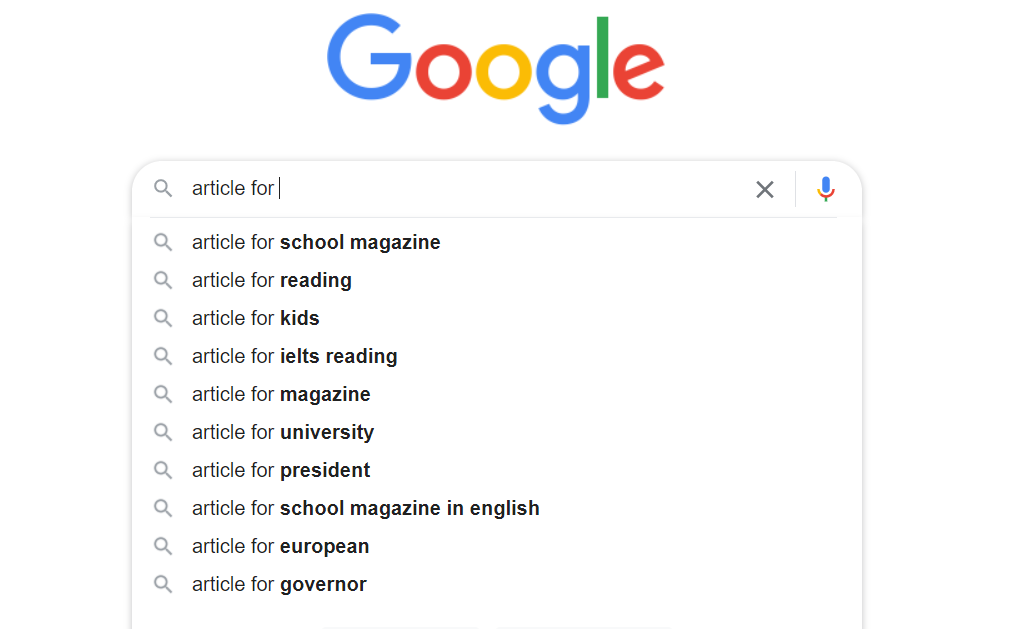


It is poosible through natural language processing (NLP) technique. Here, we will use NLP and try to make a prediction model using Bidirectional LSTM (Long short-term memory) model that will predict next words of sentence.
 

<a name="ilp"></a>
# Import necessary libraries and packages 

In [ ]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

<a name="di"></a>
# Dataset information

**Import Medium-articles-dataset:**

This dataset contains information about randomly chosen medium articles published in 2019 from these 7 publications:

- Towards Data Science
- UX Collective
- The Startup
- The Writing Cooperative
- Data Driven Investor
- Better Humans
- Better Marketing


In [ ]:
medium_data = pd.read_csv('../input/medium-articles-dataset/medium_data.csv')
medium_data.head()

Here, we have a **10 different fields and 6508 records** but we will only use **title field** for predicting next word. 

In [ ]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

<a name="preprocess"></a>
# Display titles of various articles  and preprocess them

In [ ]:
medium_data['title']

<a name="remv"></a>
#### Removing unwanted characters and words in titles

Looking at titles, we can see there are some of unwanted characters and words in it which can not be useful for us to predict infact it might decrease our model accuracy so we have to remove it.

In [ ]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

<a name="token"></a>
#### Tokenzation

Tokenzaion is the process in which we provide an unique id to all the words and make a word index or we can say vocabulary.

In [ ]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

<a name="ngram"></a>
#### Titles text into sequences and make n_gram model

suppose, we have sentence like **"I am Yash"** and this will convert into a sequence with their respective tokens **{'I': 1,'am': 2,'Yash': 3}**. Thus, output will be  **[ '1' ,'2' ,'3' ]**

Likewise, our all titles will be converted into sequences.

Then,
we will make a n_gram model for good prediction.

Below image explain about everything.

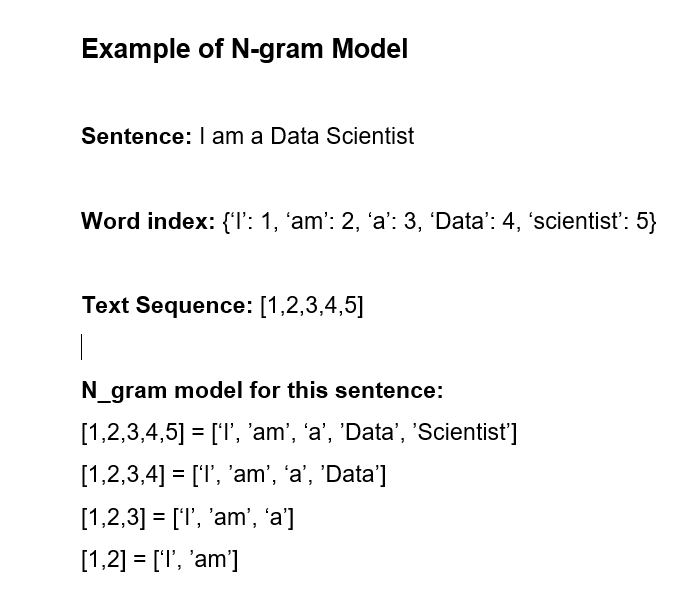


In [ ]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

<a name="pad"></a>
#### Make all titles with same length by using padding

The length of every title has to be the same. To make it, we need to find a title that has a maximum length, and based on that length, we have to pad rest of titles.

In [ ]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

<a name="xy"></a>
# Prepare features and labels

Here, we consider **last element of all sequences as a label**.Then,
We need to perform **onehot encoding on labels corresponding to total_words.**

In [ ]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
print(xs[5])
print(labels[5])
print(ys[5][14])

<a name="blstm"></a>
# Architechture of Bidirectional LSTM Neural Network

Long Short-Term Memory (LSTM) networks is an advance recurrent neural network which is apable to store order states by using its cell state feature.

Image reference: https://www.researchgate.net/figure/The-structure-of-the-Long-Short-Term-Memory-LSTM-neural-network-Reproduced-from-Yan_fig8_334268507
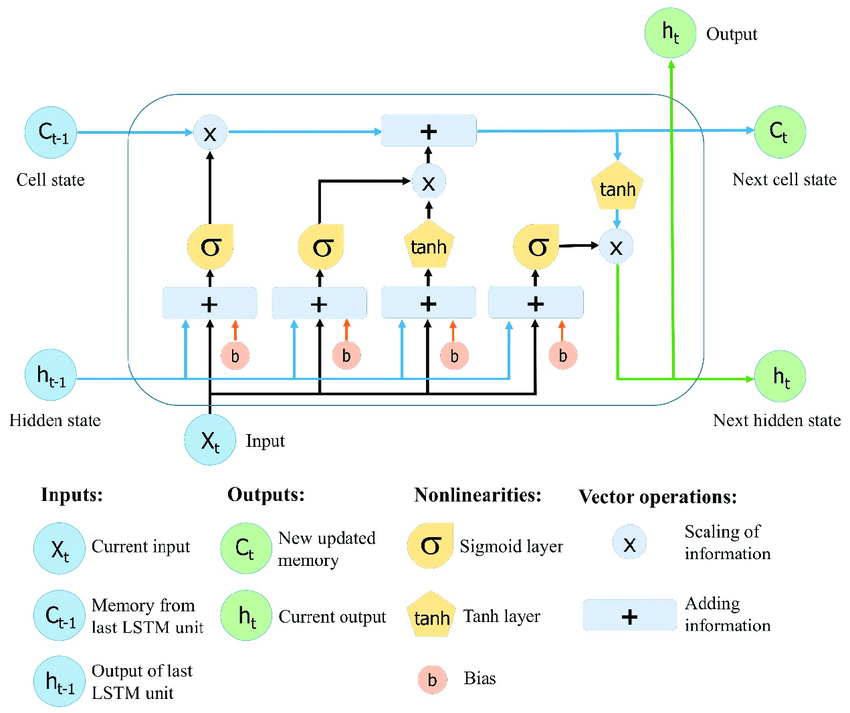

**Bidirectional LSTM**
Image reference: https://paperswithcode.com/method/bilstm
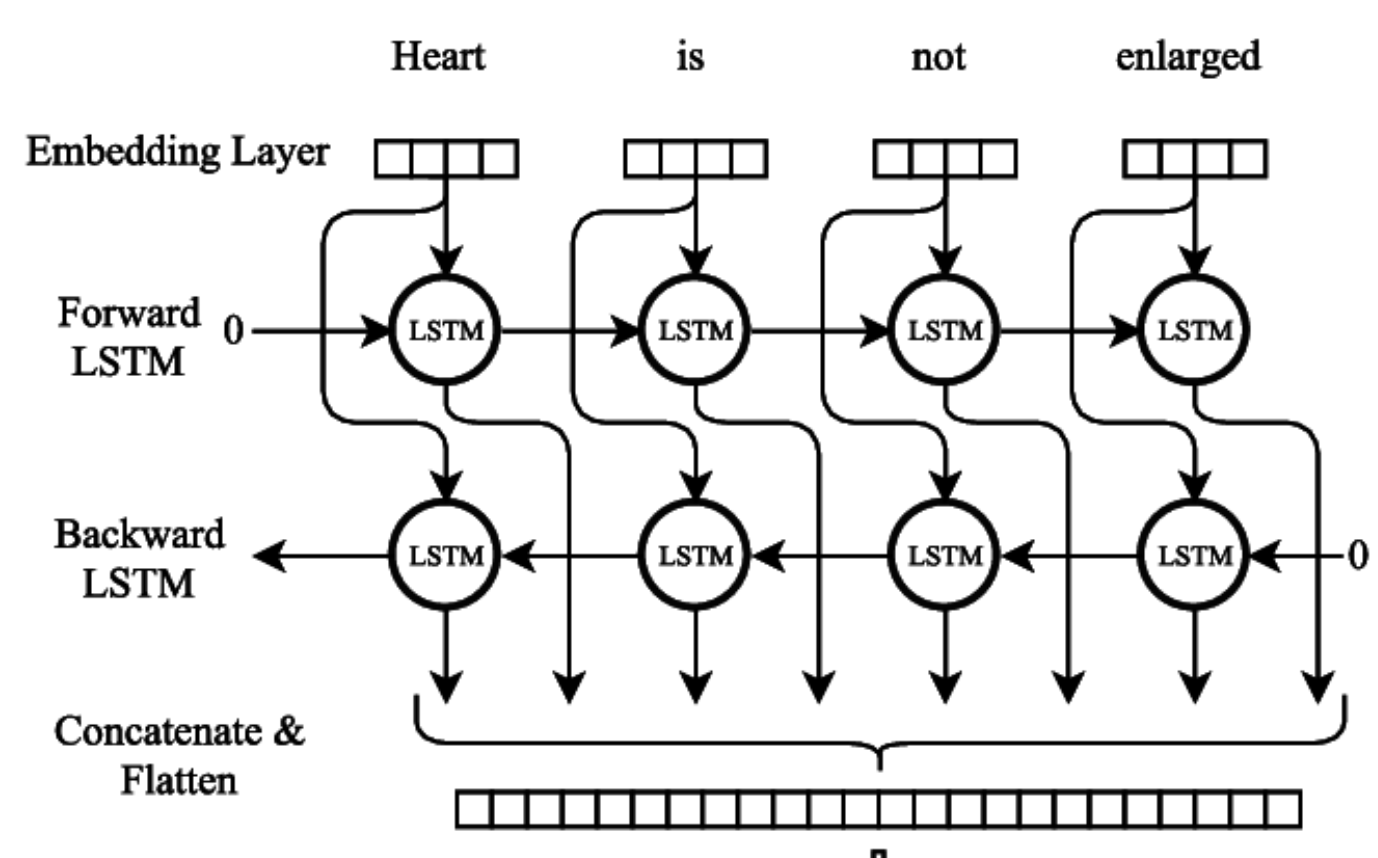

<a name="train"></a>
# Bi- LSTM Neural Network Model training

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=50, verbose=1)
#print model.summary()
print(model)


<a name="acc"></a>
# Plotting model accuracy and loss

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

<a name="new"></a>
# Predicting next word of title

In [ ]:
seed_text = "implementation of"
next_words = 2
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)